# HMM analysis

This is the notebook related to HMM data analysis. To run this, please uncomment all the cells an press "Run all" button.

In [1]:
# Set the path and input parameters
import os
# Set the main directory of the project
directory = os.getcwd() 

In [2]:
# Import the libraries and functions
from functions import *


Here we will construct and analyze HMM models retrieved from the alignments. We will utilize several databases as sources to enhance our analysis and gain valuable insights from the generated HMM profiles.
- **Reference Proteome 75%**: the database of protein sequences.
- **InterPro**: the database of protein domains.

## Load the dataframes

After performing `hmmsearch` against `RP 75%`, we obtain the dataframe `hmmsearch_results_clustal` with the statistics. E-value and score shows the significance of the particular hit, and the region related information (hmm, alignment, envelope) helps in further comparison with the existing HMMs.

In [3]:
# Dataframe of the hmmsearch results
hmmsearch_results_clustal = pd.read_csv("{}/results/hmms/hmmsearch/hmmsearch_clustal_combined.csv".format(directory))

num_ali = hmmsearch_results_clustal["query_id"].nunique()
num_hmm = hmmsearch_results_clustal["hmm_id"].nunique()
print("The number of generated DisProt-HMMs for the {} alignments: {}".format(num_ali, num_hmm))
hmmsearch_results_clustal.head()

The number of generated DisProt-HMMs for the 1971 alignments: 2536


,E-value,score,bias,exp,N,query_id,hmm_id,Sequence,profile_seq,target_seq,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length
0,1.400000e-36,136.3,3.7,1.0,1,A0A068MVV3,A0A068MVV3_1-65,G5J8E1,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,1,65,65,1,65,65
1,1.700000e-36,136.1,3.7,1.0,1,A0A068MVV3,A0A068MVV3_1-65,T2JHR4,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,4,68,65,4,68,65
2,1.700000e-36,136.1,3.5,1.0,1,A0A068MVV3,A0A068MVV3_1-65,B1X0A9,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,1,65,65,1,65,65
3,1.900000e-36,135.9,4.4,1.0,1,A0A068MVV3,A0A068MVV3_1-65,B7K2J1,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMIKNRQQSMLERAAAEIGVEVEKDYWTTIQ...,1,65,65,1,65,65,1,65,65
4,2.200000e-36,135.7,3.1,1.0,1,A0A068MVV3,A0A068MVV3_1-65,A3IQT3,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAASEIGVDVETDYWTTIQ...,1,65,65,1,65,65,1,65,65


We took the results of `hmmsearch` and performed a search against InterPro database. Thus we obtained the Pfam domains corresponding to the results from `hmmsearch`. Here I directly compared two models: Pfam-HMM and DisProt-HMM. 

The following types of overlap were calculated:
- the total overlap (`overl_len`) - in amino acids
- the common part divided by **Pfam-HMM** length (`overl_pfam`) - %
- the common part divided by **DisProt-HMM** length (`overl_ali`) - %
- and the overall overlap: the common part divided by the **maximum length** combined by Pfam-HMM and DisProt-HMM lengths together (`overl_perc`) - %.

The column `overlap_sym` serves as a quality estimator. If it's less or equal than one, then we calculated the other kinds of overlap correctly.

After that, I added the column `overlap_type`: **full** ($\geq$ 75%), **partial** ($\geq$ 25% and <75%) and **no** (<25%).

In [4]:
# Load a dataframe of Pfam regions
pfam_clustal = pd.read_csv("{}/results/pfam/pfam_overlap/pfam_disprot.csv".format(directory))
num_proteins = pfam_clustal["query_id"].nunique()
num_disprot_hmms = pfam_clustal["hmm_id"].nunique()
print("The number of unique DisProt-HMMs for the {} alignments: {}".format(num_proteins, num_disprot_hmms))

# Calculate the overlap type based on the thresholds
pfam_clustal["overlap_type"] = pfam_clustal["overl_perc"].apply(categorize_overlap) # based on overlap percentage

# Add separate columns for each type of the overlap
pfam_clustal_indicator = pd.get_dummies(pfam_clustal["overlap_type"]).astype(bool)
pfam_clustal = pd.concat([pfam_clustal, pfam_clustal_indicator], axis=1)
pfam_clustal.head()

The number of unique DisProt-HMMs for the 1734 alignments: 2200


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,query_id,hmm_id,hmm_from,hmm_to,...,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym,overlap_type,full,no,partial
0,A0A010Q2P2,PF01336,IPR004365,187,267,81,Q1K7R9,Q1K7R9_111-173,1,55,...,0,0.00,0.0,179,0.00,0.00,no,False,True,False
1,A0A010Q2P2,PF04057,IPR007199,7,109,103,Q1K7R9,Q1K7R9_111-173,1,55,...,0,0.00,0.0,161,0.00,0.00,no,False,True,False
2,A0A010Q2P2,PF08646,IPR013955,452,597,146,Q1K7R9,Q1K7R9_111-173,1,55,...,0,0.00,0.0,774,0.00,0.00,no,False,True,False
3,A0A010Q2P2,PF16900,IPR031657,296,393,98,Q1K7R9,Q1K7R9_111-173,1,55,...,0,0.00,0.0,414,0.00,0.00,no,False,True,False
4,A0A010Q304,PF02775,IPR011766,499,646,148,P07342,P07342_580-595,1,16,...,16,10.81,100.0,133,10.81,19.51,no,False,True,False


## MSA analysis

This part of the notebook refers to the analysis of MSA built with the help of ClustalOmega tool. We start with a data frame generation which will contain the main parameters of MSA: number of sequences (rows) and number of amino acids in the alignment (columns).

In [5]:
# Create the data frame of MSA length
hmm_ids = []
msa_rows = [] # the number of sequences in the MSA
msa_columns = [] # the number of amino acids in the MSA

# Define a path to the folder with DisProt-HMMs
dir_hmm = "{}/results/hmms/hmmbuild/".format(directory)
hmmbuild_files = [file for file in os.listdir(dir_hmm) if file.endswith(".hmm")]

for file_name in hmmbuild_files:
    file_path = os.path.join(dir_hmm, file_name)

    with open(file_path, "r") as file:
        content = file.read()
        # Extract the data from the fields NAME, LENG and NSEQ
        pattern = re.compile(r"NAME\s+(\S+)\s*\n.*\bLENG\s*(\d+)\b.*\bNSEQ\s*(\d+)\b", re.DOTALL)
        matches = pattern.findall(content)

        for name, nseq_value, leng_value in matches:
            hmm_ids.append(name.strip())
            msa_rows.append(int(leng_value))
            msa_columns.append(int(nseq_value))

msa_df = pd.DataFrame({"hmm_id": hmm_ids, "rows": msa_rows, "columns": msa_columns})
# Extract hmm_length from the pfam_clustal data frame
msa_df = pd.merge(msa_df, pfam_clustal[["hmm_id", "hmm_length", "query_id"]], on="hmm_id", how="right")
msa_df["hmm_length"] = msa_df["hmm_length"].fillna(0).astype(int)
# msa_df["uniprot_id"] = msa_df["hmm_id"].str.split("_", expand=True)[0]
msa_df.head()

,hmm_id,rows,columns,hmm_length,query_id
0,Q1K7R9_111-173,198,60,55,Q1K7R9
1,Q1K7R9_111-173,198,60,55,Q1K7R9
2,Q1K7R9_111-173,198,60,55,Q1K7R9
3,Q1K7R9_111-173,198,60,55,Q1K7R9
4,P07342_580-595,195,16,16,P07342


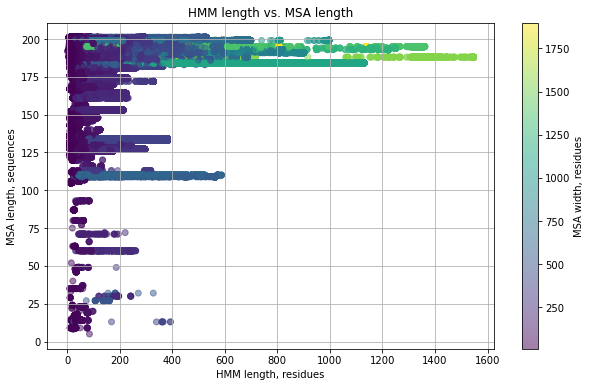

In [6]:
# Scatterplot of MSA length and HMM length
fig = plt.figure(figsize=(10, 6))

plt.scatter(msa_df["hmm_length"], msa_df["rows"], alpha=0.5, c=msa_df["columns"], cmap="viridis")

plt.xlabel("HMM length, residues")
plt.ylabel("MSA length, sequences")
plt.title("HMM length vs. MSA length")
plt.grid()

cbar = plt.colorbar(label="MSA width, residues")
# plt.savefig("{}/plots/msa_length.png".format(directory), facecolor="white", dpi=300) 
plt.show()

In [7]:
# Load the data with statistics
clustal_stats = pd.read_csv("{}/results/stats_total.csv".format(directory))
clustal_stats.head()

,pos,query_id,occupancy,entropy,counts
0,0,A1L1Q4,0.875000,0.719765,"[('G', 38), ('Q', 35), ('M', 27), ('E', 16), (..."
1,1,A1L1Q4,0.921875,0.771888,"[('E', 43), ('T', 30), ('A', 18), ('M', 14), (..."
2,2,A1L1Q4,0.932292,0.517319,"[('E', 96), ('Q', 37), ('A', 13), ('D', 7), ('..."
3,3,A1L1Q4,0.947917,0.672342,"[('E', 57), ('K', 39), ('G', 24), ('N', 20), (..."
4,4,A1L1Q4,0.953125,0.649866,"[('E', 69), ('H', 45), ('L', 13), ('D', 10), (..."


/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4692/3155759845.py:20: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


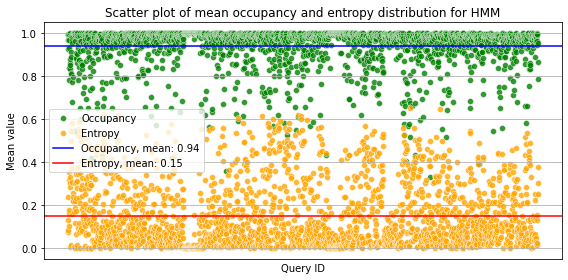

In [8]:
# Plot the mean occupancy and mean entropy distribution
mean_occupancy = clustal_stats.groupby("query_id")["occupancy"].mean().reset_index()
mean_entropy = clustal_stats.groupby("query_id")["entropy"].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.scatterplot(data=mean_occupancy, x="query_id", y="occupancy", color="green", label="Occupancy", alpha=0.8)
sns.scatterplot(data=mean_entropy, x="query_id", y="entropy", color="orange", label="Entropy", alpha=0.8)

# Calculate and plot mean values
mean_occupancy_value = mean_occupancy["occupancy"].mean()
mean_entropy_value = mean_entropy["entropy"].mean()

plt.axhline(mean_occupancy_value, color="blue", label=f"Occupancy, mean: {mean_occupancy_value:.2f}")
plt.axhline(mean_entropy_value, color="red", label=f"Entropy, mean: {mean_entropy_value:.2f}")

plt.xlabel("Query ID")
plt.ylabel("Mean value")
plt.title("Scatter plot of mean occupancy and entropy distribution for HMM")

plt.xticks([])
plt.legend()
plt.grid()
plt.tight_layout()

# plt.savefig("{}/plots/occentrdistr.png".format(directory), facecolor="white", dpi=300) 
plt.show()

## Gaps analysis

In [9]:
# Create a dataframe with the gaps
gaps_df = hmmsearch_results_clustal[["E-value", "query_id", "hmm_id", "Sequence", 
                                     "profile_seq", "target_seq",
                                     "hmm_from", "hmm_to", "hmm_length",
                                     "ali_from", "ali_to", "ali_length"]].copy()

gaps_df["gap_hmm"] = gaps_df["profile_seq"].apply(lambda x: x.count("."))
gaps_df["gap_ali"] = gaps_df["target_seq"].apply(lambda x: x.count("-"))
gaps_df.head()

,E-value,query_id,hmm_id,Sequence,profile_seq,target_seq,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,gap_hmm,gap_ali
0,1.400000e-36,A0A068MVV3,A0A068MVV3_1-65,G5J8E1,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,1,65,65,0,0
1,1.700000e-36,A0A068MVV3,A0A068MVV3_1-65,T2JHR4,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,4,68,65,0,0
2,1.700000e-36,A0A068MVV3,A0A068MVV3_1-65,B1X0A9,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,1,65,65,0,0
3,1.900000e-36,A0A068MVV3,A0A068MVV3_1-65,B7K2J1,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMIKNRQQSMLERAAAEIGVEVEKDYWTTIQ...,1,65,65,1,65,65,0,0
4,2.200000e-36,A0A068MVV3,A0A068MVV3_1-65,A3IQT3,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAASEIGVDVETDYWTTIQ...,1,65,65,1,65,65,0,0


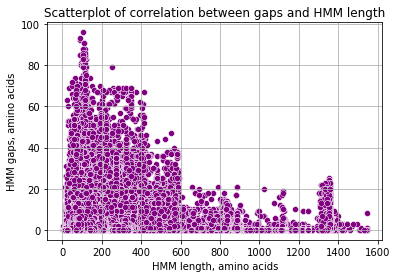

In [10]:
# HMM and gaps length comparison
sns.scatterplot(x="hmm_length", y="gap_hmm", color="purple", data=gaps_df)

plt.xlabel("HMM length, amino acids")
plt.ylabel("HMM gaps, amino acids")
plt.title("Scatterplot of correlation between gaps and HMM length")
plt.grid()
# plt.savefig("{}/plots/hmmgap.png".format(directory), facecolor="white", dpi=300) 
plt.show()

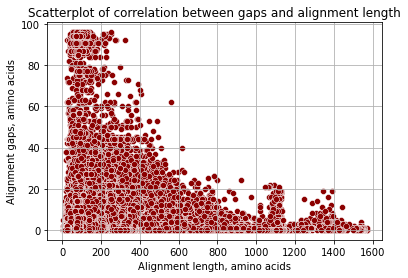

In [11]:
# Target sequences and gaps length comparison
sns.scatterplot(x="ali_length", y="gap_ali", color="darkred", data=gaps_df)

plt.xlabel("Alignment length, amino acids")
plt.ylabel("Alignment gaps, amino acids")
plt.title("Scatterplot of correlation between gaps and alignment length")
plt.grid()
# plt.savefig("{}/plots/aligap.png".format(directory), facecolor="white", dpi=300) 
plt.show()

We can observe that for some of the sequences (both HMM and the target sequences) there are cases when the length of the alignment is larger that of the aligned sequence.

In [12]:
# Retrieve the instances for the longer gaps size of HMM and the target sequences
longer_gaps_hmm = gaps_df[gaps_df["gap_hmm"] > gaps_df["hmm_length"]]
longer_gaps_ali = gaps_df[gaps_df["gap_ali"] > gaps_df["ali_length"]]

print("Number of HMM IDs for instances with longer gaps for query sequence:", len(longer_gaps_hmm["hmm_id"].unique()))
print("Number of corresponding pairwise alignments:", len(longer_gaps_hmm))

print("Number of HMM IDs for instances with longer gaps for target sequence:", len(longer_gaps_ali["hmm_id"].unique()))
print("Number of corresponding pairwise alignments:", len(longer_gaps_ali))

Number of HMM IDs for instances with longer gaps for query sequence: 23
Number of corresponding pairwise alignments: 53
Number of HMM IDs for instances with longer gaps for target sequence: 26
Number of corresponding pairwise alignments: 858


In [13]:
# Extract a df for longer gaps of HMMs
longer_gaps_hmm_df = longer_gaps_hmm[["hmm_id", "hmm_length"]]
start_end_values = longer_gaps_hmm_df["hmm_id"].str.split("_", expand=True)

start_values = start_end_values[1].str.split("-", expand=True)[0].astype(int)
end_values = start_end_values[1].str.split("-", expand=True)[1].astype(int)
longer_gaps_hmm_df["disprot_length"] = end_values - start_values + 1

# Group by hmm_id and aggregate the unique hmm_length values
longer_gaps_hmm_df = longer_gaps_hmm_df.groupby("hmm_id").agg({
    "disprot_length": lambda x: tuple(sorted(x.unique())),
    "hmm_length": lambda x: tuple(sorted(x.unique()))  
}).reset_index()

longer_gaps_hmm_df.head()

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4692/1548242222.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longer_gaps_hmm_df["disprot_length"] = end_values - start_values + 1


,hmm_id,disprot_length,hmm_length
0,J7QLC0_1006-1706,"(701,)","(25, 39)"
1,O13916_25-80,"(56,)","(14,)"
2,O23764_1-422,"(422,)","(34, 49)"
3,P06701_216-549,"(334,)","(89, 90)"
4,P08083_1-90,"(90,)","(32,)"


In [14]:
# Extract a df for longer gaps of target sequences
longer_gaps_ali_df = longer_gaps_ali[["hmm_id", "ali_length"]]
start_end_values = longer_gaps_ali_df["hmm_id"].str.split("_", expand=True)

start_values = start_end_values[1].str.split("-", expand=True)[0].astype(int)
end_values = start_end_values[1].str.split("-", expand=True)[1].astype(int)
longer_gaps_ali_df["disprot_length"] = end_values - start_values + 1

# Group by hmm_id and aggregate the unique ali_length values
longer_gaps_ali_df = longer_gaps_ali_df.groupby("hmm_id").agg({
    "disprot_length": lambda x: tuple(sorted(x.unique())),
    "ali_length": lambda x: tuple(sorted(x.unique()))  
}).reset_index()

longer_gaps_ali_df.head()

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4692/1551366838.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longer_gaps_ali_df["disprot_length"] = end_values - start_values + 1


,hmm_id,disprot_length,ali_length
0,A0A2K8FR49_1-172,"(172,)","(26,)"
1,A0A3N4AZ09_21-215,"(195,)","(60, 61, 62, 65, 66, 67, 72, 85)"
2,C4M0U8_1-150,"(150,)","(29, 39, 46, 51, 54, 56, 57, 58, 59, 60, 61, 6..."
3,C4R4Y0_1454-1743,"(290,)","(18,)"
4,E5LC01_640-880,"(241,)","(1,)"


## Distribution analysis

Here we will look at the distribution of proteins matches from RP 75%.

In [15]:
# Group by the number of sequences for each HMM
sequence_counts = hmmsearch_results_clustal.groupby("hmm_id")["Sequence"].count().reset_index()
sequence_counts.head()

,hmm_id,Sequence
0,A0A068MVV3_1-65,355
1,A0A097F4I8_1-24,9
2,A0A097F4I8_74-99,2
3,A0A0G2JXC5_129-160,2773
4,A0A0G2JXC5_173-204,3250


/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4692/2795886238.py:8: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


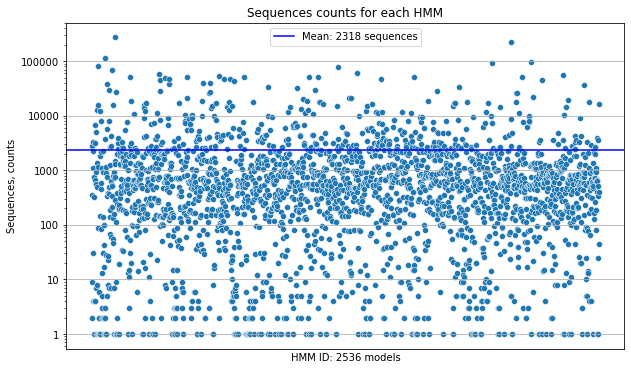

In [16]:
# Plot of sequence counts
plt.figure(figsize=(10, 6))
sns.scatterplot(x="hmm_id", y="Sequence", data=sequence_counts, edgecolors=None)

mean_sequence_count = np.mean(sequence_counts["Sequence"])
plt.axhline(mean_sequence_count, color="blue", label=f"Mean: {mean_sequence_count:.0f} sequences")

plt.xticks([])
plt.yscale("log")
yticks_values = [1, 10, 100, 1000, 10000, 100000] 
plt.yticks(yticks_values, labels=yticks_values)

num_rows = sequence_counts.shape[0] # the number of DisProt-HMMs

plt.xlabel(f"HMM ID: {num_rows} models")
plt.ylabel("Sequences, counts")
plt.title("Sequences counts for each HMM")
plt.grid()
plt.legend()
# plt.savefig("{}/plots/seqdistribution.png".format(directory), facecolor="white", dpi=300) 
plt.show()

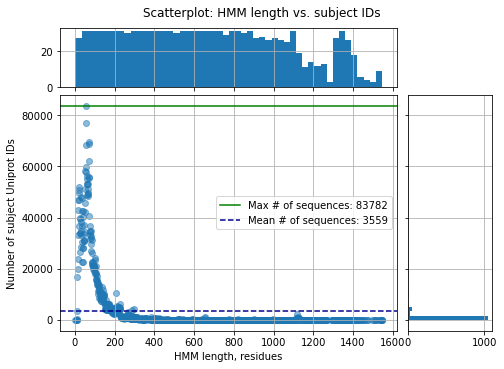

In [17]:
# Scatter plot of HMM length and subject IDs
hmmlen_unid = pfam_clustal.groupby("hmm_length")["uniprot_id"].nunique()

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.15, right=0.9, bottom=0.2, top=0.9,
                      wspace=0.05, hspace=0.05)  # Adjust the left spacing

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(hmmlen_unid.index, hmmlen_unid.values, alpha=0.5, cmap="Blues")

max_y_value = hmmlen_unid.values.max()
mean_y_value = hmmlen_unid.values.mean()

# ax.axvline(x=hmmlen_unid.index[np.argmax(hmmlen_unid.values)], ymin=0, 
#            ymax=max_y_value/hmmlen_unid.values[np.argmax(hmmlen_unid.values)], 
#            color="green", linestyle="-", label=f"Max # of sequences: {max_y_value}")

ax.axhline(y=max_y_value, color="green", linestyle="-", label=f"Max # of sequences: {max_y_value:.0f}")
ax.axhline(y=mean_y_value, color="darkblue", linestyle="--", label=f"Mean # of sequences: {mean_y_value:.0f}")

ax_histx.hist(hmmlen_unid.index, bins=50)
ax_histy.hist(hmmlen_unid.values, bins=50, orientation="horizontal")

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_xlabel("HMM length, residues")
ax.set_ylabel("Number of subject Uniprot IDs")
fig.suptitle("Scatterplot: HMM length vs. subject IDs", y=0.95)

ax.grid()
ax_histx.grid()
ax_histy.grid()
ax.legend()

plt.savefig("{}/plots/scatter_hmmlen_unid.png".format(directory), facecolor="white", dpi=300) 
plt.show()

## Defining metric for analysis: HMM and alignment length comparison

Here we compare the length of HMM and the corresponding length of the alignment. There can be 3 options: they are equal or one of them longer or shorter than another because of some insertions/deletions of the alignment.

In [18]:
# Compare HMMs and alignments lengths
hmms = len(hmmsearch_results_clustal)
match_hmms = len(hmmsearch_results_clustal[hmmsearch_results_clustal["hmm_length"] == hmmsearch_results_clustal["ali_length"]])
longer_hmms = len(hmmsearch_results_clustal[hmmsearch_results_clustal["hmm_length"] > hmmsearch_results_clustal["ali_length"]])
shorter_hmms = len(hmmsearch_results_clustal[hmmsearch_results_clustal["hmm_length"] < hmmsearch_results_clustal["ali_length"]])

print("The number of instances: {}, from which HMM regions:".format(hmms))
print("- matching the alignment length: {} ({:.2f}%)".format(match_hmms, match_hmms/hmms * 100))
print("- longer than the alignment length: {} ({:.2f}%)".format(longer_hmms, longer_hmms/(hmms - match_hmms) * 100))
print("- shorter than the alignment length: {} ({:.2f}%)".format(shorter_hmms, shorter_hmms/(hmms - match_hmms) * 100))

The number of instances: 5878578, from which HMM regions:
- matching the alignment length: 2906648 (49.44%)
- longer than the alignment length: 1097774 (36.94%)
- shorter than the alignment length: 1874156 (63.06%)


The number of the pairwise alignments matching the length of the alignment and not are more or less equal in proportion **(47,3% and 52,7% respectively)**. Out of non-matching the proportion of the longer HMMs and shorter HMMs is different **(24,3% and 75,7%)**. 

So, mostly we are dealing with the cases where the length of the alignment is longer than the HMM.

In [19]:
# Longer HMMs
longer_clustal = hmmsearch_results_clustal[hmmsearch_results_clustal["hmm_length"] > hmmsearch_results_clustal["ali_length"]]
longer_clustal["hmm_ali_diff"] = longer_clustal["hmm_length"] - longer_clustal["ali_length"]
longer_clustal.head()

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4692/3691752855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longer_clustal["hmm_ali_diff"] = longer_clustal["hmm_length"] - longer_clustal["ali_length"]


,E-value,score,bias,exp,N,query_id,hmm_id,Sequence,profile_seq,target_seq,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length,hmm_ali_diff
13,9.900000e-36,133.6,1.6,1.0,1,A0A068MVV3,A0A068MVV3_1-65,A0YVF1,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MGTEDQARALMMRHHHLIKNRQQSMLNRTADEVGLEA-GNYWNHIQ...,1,65,65,1,64,64,1,64,64,1
14,9.900000e-36,133.6,1.6,1.0,1,A0A068MVV3,A0A068MVV3_1-65,U7QP13,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MGTEDQARALMMRHHHLIKNRQQSMLNRTADEVGLEA-GNYWNHIQ...,1,65,65,1,64,64,1,64,64,1
17,1.100000e-35,133.5,1.0,1.0,1,A0A068MVV3,A0A068MVV3_1-65,A0A261KNA6,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MDIENQARALMMRHHNLIKNRQQSMLNRTASEVGVEAD-NYWGNIQ...,1,65,65,1,64,64,1,64,64,1
21,4.800000e-35,131.4,0.7,1.0,1,A0A068MVV3,A0A068MVV3_1-65,A0A3N6RSN1,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSVENQARSLMIRHHNLVKNRQQSMLNRTATEVGVEAD-NYWGNIQ...,1,65,65,1,64,64,1,64,64,1
22,6.300000e-35,131.0,1.1,1.0,1,A0A068MVV3,A0A068MVV3_1-65,A0A0F5Y9P9,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MGTEDQARALMIRHHQIIKNRQQSMLNRAAAEVGLEA-GDYWNHIQ...,1,65,65,1,64,64,1,64,64,1


In [20]:
# Shorter HMMs
shorter_clustal = hmmsearch_results_clustal[hmmsearch_results_clustal["hmm_length"] < hmmsearch_results_clustal["ali_length"]]
shorter_clustal["hmm_ali_diff"] = shorter_clustal["ali_length"] - shorter_clustal["hmm_length"]
shorter_clustal.head()

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4692/3204041724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shorter_clustal["hmm_ali_diff"] = shorter_clustal["ali_length"] - shorter_clustal["hmm_length"]


,E-value,score,bias,exp,N,query_id,hmm_id,Sequence,profile_seq,target_seq,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,env_from,env_to,env_length,hmm_ali_diff
6,3.100000e-36,135.2,3.1,1.0,1,A0A068MVV3,A0A068MVV3_1-65,A0A8J6RJ94,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvd.sdywsti...,MSTQEQARALMMRHHHIIKNRQQSMLGRTAAEVGMDVEgSEYWNHI...,1,65,65,1,66,66,1,66,66,1
8,5.800000e-36,134.4,1.4,1.0,1,A0A068MVV3,A0A068MVV3_1-65,A0A1D9FU84,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldv.dsdywsti...,MSTQEKARALMMNHHHMIKNRQQSMLGRVASEVGLDSlDSDYWGTI...,1,65,65,1,66,66,1,66,66,1
9,5.800000e-36,134.4,1.4,1.0,1,A0A068MVV3,A0A068MVV3_1-65,F4XPR6,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldv.dsdywsti...,MSTQEKARALMMNHHHMIKNRQQSMLGRVASEVGLDSlDSDYWGTI...,1,65,65,1,66,66,1,66,66,1
12,5.900000e-36,134.3,3.5,1.0,1,A0A068MVV3,A0A068MVV3_1-65,K9WK15,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQEQARALMMRHHHVVKNRQQSMLNRAAAEIGFEGTTEYWNHIQ...,1,65,65,1,66,66,1,66,66,1
15,1.000000e-35,133.6,1.3,1.0,1,A0A068MVV3,A0A068MVV3_1-65,A0A1D8TLA5,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldv.dsdywsti...,MSTQEKARALMMNHHHMIKNRQQSMLGRVASEVGLDSlDSDYWGTI...,1,65,65,1,66,66,1,66,66,1


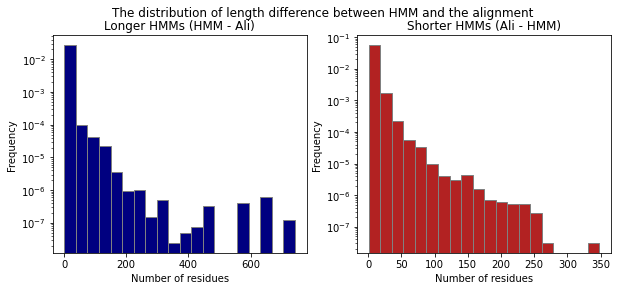

In [21]:
# Plot the histogram of residues difference distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(longer_clustal["hmm_ali_diff"], bins=20, color="navy", edgecolor="gray", density=True)
ax2.hist(shorter_clustal["hmm_ali_diff"], bins=20, color="firebrick", edgecolor="gray", density=True)

plt.suptitle("The distribution of length difference between HMM and the alignment")
ax1.set_title("Longer HMMs (HMM - Ali)")
ax2.set_title("Shorter HMMs (Ali - HMM)")
ax1.set_xlabel("Number of residues")
ax2.set_xlabel("Number of residues")
ax1.set_ylabel("Frequency")
ax2.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")

# plt.savefig("{}/plots/hmmali.png".format(directory), facecolor="white", dpi=300) 
plt.show()

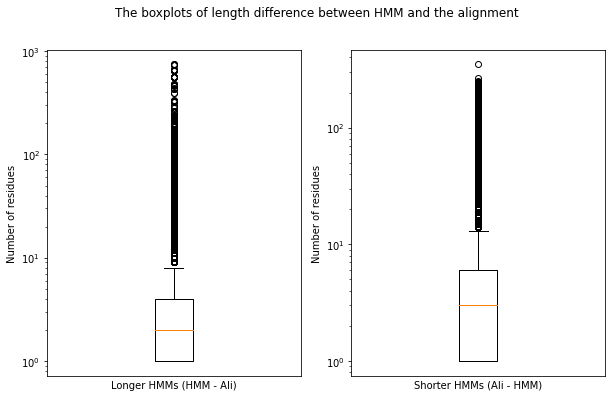

In [22]:
# Plot the boxplot of residues difference distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
box1 = ax1.boxplot(longer_clustal["hmm_ali_diff"])
box2 = ax2.boxplot(shorter_clustal["hmm_ali_diff"])
plt.suptitle("The boxplots of length difference between HMM and the alignment")
ax1.set_xlabel("Longer HMMs (HMM - Ali)")
ax2.set_xlabel("Shorter HMMs (Ali - HMM)")
ax1.set_ylabel("Number of residues")
ax2.set_ylabel("Number of residues")
ax1.set_xticks(ax1.get_xticks()[1:])
ax2.set_xticks(ax2.get_xticks()[1:])
ax1.set_yscale("log")
ax2.set_yscale("log")

# plt.savefig("{}/plots/outliers.png".format(directory), facecolor="white", dpi=300) 
plt.show()

In [23]:
# Calculate the outliers proportion in the data frames
threshold_long = box1["whiskers"][1].get_ydata()[1]
threshold_short = box2["whiskers"][1].get_ydata()[1]
long_outl = len(longer_clustal[longer_clustal["hmm_ali_diff"] >= threshold_long])
short_outl = len(shorter_clustal[shorter_clustal["hmm_ali_diff"] >= threshold_short])

print("Outliers in the longer HMMs (more than {} residues): {:.1f}%".format(int(threshold_long), long_outl/longer_hmms * 100))
print("Outliers in the shorter HMMs (more than {} residues): {:.1f}%".format(int(threshold_short), short_outl/shorter_hmms * 100))

Outliers in the longer HMMs (more than 8 residues): 13.0%
Outliers in the shorter HMMs (more than 13 residues): 7.6%


Retrieving outliers is an important step in our case. Since we cannot use fields `hmm_from/hmm_to` as it doesn't capture the actual position, we need to analyse if the `ali_from/ali_to` are the reliable fields. In case the difference between HMMs and the alignments is huge, we need to find a solution. If the difference is not so big in general, we can rely on the alignment information from the `hmmsearch` results.

Thus, obtaining about 10% of instances with a huge difference between HMMs and the alignments, we can use the `ali_from/ali_to` columns for the further comparison with Pfam.

In [24]:
# # Scatter plot of Pfam IDs for each HMM ID
# plt.figure(figsize=(10, 6)) 

# plt.scatter(pfam_clustal.groupby("hmm_id")["pfam_id"].count().index, 
#             pfam_clustal.groupby("hmm_id")["pfam_id"].count().values,
#             c=pfam_clustal.groupby("hmm_id")["overl_perc"].mean(),
#             alpha=0.7)

# plt.xlabel("HMM ID")
# plt.ylabel("Pfam ID, counts")
# plt.title("Count of Pfam hits per HMM ID")
# plt.grid()
# plt.colorbar(label="Overlap, %")
# plt.yscale("log")
# plt.xticks([])
# # plt.savefig("{}/plots/pfamforhmm.png".format(directory), facecolor="white", dpi=300) 
# plt.show()

## DisProt-HMMs vs Pfam-HMMs: overlap analysis

We focus on 4 types of instances:

1. DisProt-HMMs fully overlap Pfam-HMMs;
2. DisProt-HMMs partially overlap Pfam-HMMs;
3. DisProt-HMMs do not overlap Pfam-HMMs;
4. No Pfam-HMMs were found for the DisProt-HMMs.

In [25]:
# Group data by the number of proteins occurences in each type of overlap
overlap_df = pfam_clustal.groupby(["uniprot_id", "hmm_id"])[["full", "no", "partial"]].agg(
    {"full": "sum", "no": "sum", "partial": "sum"})
overlap_df.head()

full  no  partial
uniprot_id hmm_id                           
A0A010Q2P2 Q1K7R9_111-173     0   4        0
A0A010Q304 P07342_580-595     0   3        0
           P07342_647-687     0   3        0
A0A010Q3K6 Q02629_1-640       0   1        0
A0A010Q401 P32867_192-265     0   1        1

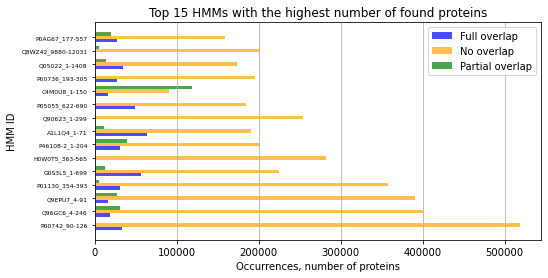

In [26]:
# Plot the top HMMs by the number of found proteins hmmsearch - by the type of overlap
plt.figure(figsize=(8, 4))

top_hmms = overlap_df.groupby("hmm_id").sum().sum(axis=1).nlargest(15).index
top_n = 15

full_occurrences = overlap_df.groupby("hmm_id")["full"].sum()
no_occurrences = overlap_df.groupby("hmm_id")["no"].sum()
partial_occurrences = overlap_df.groupby("hmm_id")["partial"].sum()

bar_width = 0.25
bar_positions = np.arange(len(top_hmms))

plt.barh(bar_positions - bar_width, full_occurrences[top_hmms], height=bar_width, label="Full overlap", color="blue", alpha=0.7)
plt.barh(bar_positions, no_occurrences[top_hmms], height=bar_width, label="No overlap", color="orange", alpha=0.7)
plt.barh(bar_positions + bar_width, partial_occurrences[top_hmms], height=bar_width, label="Partial overlap", color="green", alpha=0.7)

plt.yticks(bar_positions, top_hmms, fontsize=6)
plt.ylabel("HMM ID")
plt.xlabel("Occurrences, number of proteins")
plt.title(f"Top {top_n} HMMs with the highest number of found proteins")
plt.legend()
plt.grid(axis="x")

# plt.savefig("{}/plots/top15.png".format(directory), facecolor="white", dpi=300) 
plt.show()

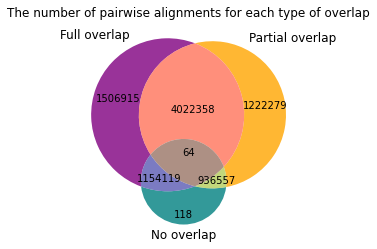

In [27]:
# Plot Venn3 diagram of pairwise alignment for each type of overlap
set_sizes = [
    len(overlap_df[overlap_df["full"] > 0]),
    len(overlap_df[overlap_df["partial"] > 0]),
    len(overlap_df[overlap_df["no"] > 0]),
    len(overlap_df[(overlap_df["full"] > 0) & (overlap_df["partial"] > 0)]),
    len(overlap_df[(overlap_df["full"] > 0) & (overlap_df["no"] > 0)]),
    len(overlap_df[(overlap_df["partial"] > 0) & (overlap_df["no"] > 0)]),
    len(overlap_df[(overlap_df["full"] > 0) & (overlap_df["partial"] > 0) & (overlap_df["no"] > 0)])
]

venn_labels = {"100": "Full", "010": "Partial", "001": "No", 
               "110": "Full & Partial", "101": "Full & No", "011": "Partial & No", 
               "111": "Full & Partial & No"}

venn3(subsets=set_sizes, set_labels=("Full overlap", "Partial overlap", "No overlap"), 
      set_colors=("purple", "orange", "teal"), alpha=0.8)
plt.title("The number of pairwise alignments for each type of overlap")

# plt.savefig("{}/plots/venn3_pairwise.png".format(directory), facecolor="white", dpi=300) 
plt.show()

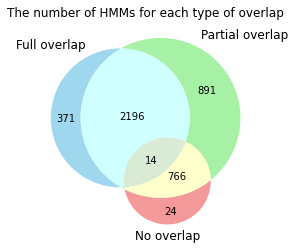

In [28]:
# Calculate set sizes based on unique hmm_id
total_instances = overlap_df.index.get_level_values('hmm_id').nunique()

set_sizes = [
    overlap_df[overlap_df["full"] > 0].index.get_level_values('hmm_id').nunique(),
    overlap_df[overlap_df["partial"] > 0].index.get_level_values('hmm_id').nunique(),
    overlap_df[overlap_df["no"] > 0].index.get_level_values('hmm_id').nunique(),
    overlap_df[(overlap_df["full"] > 0) & (overlap_df["partial"] > 0)].index.get_level_values('hmm_id').nunique(),
    overlap_df[(overlap_df["full"] > 0) & (overlap_df["no"] > 0)].index.get_level_values('hmm_id').nunique(),
    overlap_df[(overlap_df["partial"] > 0) & (overlap_df["no"] > 0)].index.get_level_values('hmm_id').nunique(),
    overlap_df[(overlap_df["full"] > 0) & (overlap_df["partial"] > 0) & (overlap_df["no"] > 0)].index.get_level_values('hmm_id').nunique()
]

set_percentages = [f"({count / total_instances * 100:.2f}%)" for count in set_sizes]

# venn_labels = {"100": "Full", "010": "Partial", "001": "No", 
#                "110": "Full & Partial", "101": "Full & No", "011": "Partial & No", 
#                "111": "Full & Partial & No"}

venn3(subsets=set_sizes, set_labels=("Full overlap", "Partial overlap", "No overlap"), 
      set_colors=("skyblue", "lightgreen", "lightcoral"), alpha=0.8)
plt.title("The number of HMMs for each type of overlap")

# plt.savefig("{}/plots/venn3_hmm.png".format(directory), facecolor="white", dpi=300) 
plt.show()

In [29]:
# Count the HMMs presented only for distinct types of overlap
full_overl_df = overlap_df[overlap_df["full"] > 0]
full_overl_hmm_ids = full_overl_df.index.get_level_values("hmm_id").unique()

partial_overl_df = overlap_df[overlap_df["partial"] > 0]
partial_overl_hmm_ids = partial_overl_df.index.get_level_values("hmm_id").unique()

no_overl_df = overlap_df[overlap_df["no"] > 0]
no_overl_hmm_ids = no_overl_df.index.get_level_values("hmm_id").unique()

print("The number of DisProt-HMMs for the full overlap:", len(full_overl_hmm_ids))
print("The number of DisProt-HMMs for the partial overlap:", len(partial_overl_hmm_ids))
print("The number of DisProt-HMMs for the no overlap:", len(no_overl_hmm_ids))

The number of DisProt-HMMs for the full overlap: 371
The number of DisProt-HMMs for the partial overlap: 891
The number of DisProt-HMMs for the no overlap: 2196


In [30]:
# Count the HMMs at the intersections (two and three types of overlap)
full_part_overl_df = overlap_df[(overlap_df["full"] > 0) & (overlap_df["partial"] > 0)]
full_part_overl_hmm_ids = full_part_overl_df.index.get_level_values("hmm_id").unique()

full_no_overl_df = overlap_df[(overlap_df["full"] > 0) & (overlap_df["no"] > 0)]
full_no_overl_hmm_ids = full_no_overl_df.index.get_level_values("hmm_id").unique()

part_no_overl_df = overlap_df[(overlap_df["partial"] > 0) & (overlap_df["no"] > 0)]
part_no_overl_hmm_ids = part_no_overl_df.index.get_level_values("hmm_id").unique()

common_df = overlap_df[(overlap_df["full"] > 0) & (overlap_df["partial"] > 0) & (overlap_df["no"] > 0)]
common_hmm_ids = common_df.index.get_level_values("hmm_id").unique()

print("The number of DisProt-HMMs for the full and partial overlaps:", len(full_part_overl_hmm_ids))
print("The number of DisProt-HMMs for the full and no overlaps:", len(full_no_overl_hmm_ids))
print("The number of DisProt-HMMs for the partial and no overlaps:", len(part_no_overl_hmm_ids))

print("The number of DisProt-HMMs for the all types of overlaps:", len(common_hmm_ids))

The number of DisProt-HMMs for the full and partial overlaps: 24
The number of DisProt-HMMs for the full and no overlaps: 341
The number of DisProt-HMMs for the partial and no overlaps: 766
The number of DisProt-HMMs for the all types of overlaps: 14


In [31]:
# Full overlap: more than 75%
full_overlap = pfam_clustal[pfam_clustal["overlap_type"] == "full"]
print("The number of pairwise alignments for fully overlapped HMMs: {}".format(len(full_overlap)))
print("The number of unique HMMs: {}".format(full_overlap["hmm_id"].nunique()))
full_overlap.head()

The number of pairwise alignments for fully overlapped HMMs: 1506917
The number of unique HMMs: 371


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,query_id,hmm_id,hmm_from,hmm_to,...,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym,overlap_type,full,no,partial
17,A0A010Q4L3,PF00258,IPR008254,417,550,134,Q9SUM3,Q9SUM3_73-303,30,163,...,122,91.04,98.39,15,89.71,94.57,full,True,False,False
28,A0A010Q4M5,PF00628,IPR019787,468,512,45,P29375,P29375_184-360,113,161,...,45,100.00,91.84,5,91.84,95.74,full,True,False,False
32,A0A010Q650,PF00957,IPR042855,31,117,87,O70480,O70480_47-117,5,71,...,67,77.01,100.00,21,77.01,87.01,full,True,False,False
36,A0A010Q7P7,PF00018,IPR001452,435,481,47,A1L1Q4,A1L1Q4_1-71,10,65,...,47,100.00,81.03,12,81.03,89.52,full,True,False,False
37,A0A010Q7P7,PF00018,IPR001452,435,481,47,Q3UKX1,Q3UKX1_1-106,31,84,...,47,100.00,83.93,10,83.93,91.26,full,True,False,False


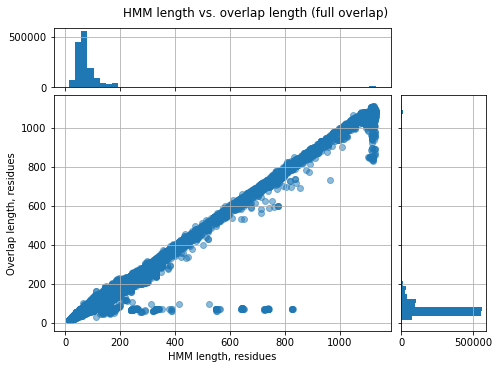

In [32]:
# 1. Scatterplot of HMM length and overlap length - full overlap
fig = plt.figure(figsize=(8, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.15, right=0.9, bottom=0.2, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(full_overlap["hmm_length"], full_overlap["overl_len"], alpha=0.5, cmap="Blues")
ax_histx.hist(full_overlap["hmm_length"], bins=50)
ax_histy.hist(full_overlap["overl_len"], bins=50, orientation="horizontal")

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_xlabel("HMM length, residues")
ax.set_ylabel("Overlap length, residues")
fig.suptitle("HMM length vs. overlap length (full overlap)", y=0.95)
ax.grid()
ax_histx.grid()
ax_histy.grid()

plt.savefig("{}/plots/fulloverlap_len.png".format(directory), facecolor="white", dpi=300) 
plt.show()

In [33]:
# Partial overlap: more than 25% and less than 75%
partial_overlap = pfam_clustal[pfam_clustal["overlap_type"] == "partial"]

print("The number of pairwise alignments for fully overlapped HMMs: {}".format(len(partial_overlap)))
print("The number of unique HMMs: {}".format(partial_overlap["hmm_id"].nunique()))
partial_overlap.head()

The number of pairwise alignments for fully overlapped HMMs: 1326756
The number of unique HMMs: 891


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,query_id,hmm_id,hmm_from,hmm_to,...,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym,overlap_type,full,no,partial
11,A0A010Q401,PF05739,IPR000727,283,332,50,P32867,P32867_192-265,2,74,...,38,76.00,52.05,48,44.71,61.79,partial,False,False,True
12,A0A010Q401,PF05739,IPR000727,283,332,50,P39926,P39926_196-269,2,74,...,38,76.00,52.05,48,44.71,61.79,partial,False,False,True
31,A0A010Q4M5,PF00628,IPR019787,1331,1374,44,P36106,P36106_1-232,28,102,...,44,100.00,61.11,29,61.11,75.86,partial,False,False,True
33,A0A010Q650,PF00957,IPR042855,31,117,87,P31109,P31109_1-93,2,90,...,68,78.16,70.10,49,58.62,73.91,partial,False,False,True
34,A0A010Q650,PF00957,IPR042855,31,117,87,P33328,P33328_1-91,2,89,...,67,77.01,69.79,50,57.76,73.22,partial,False,False,True


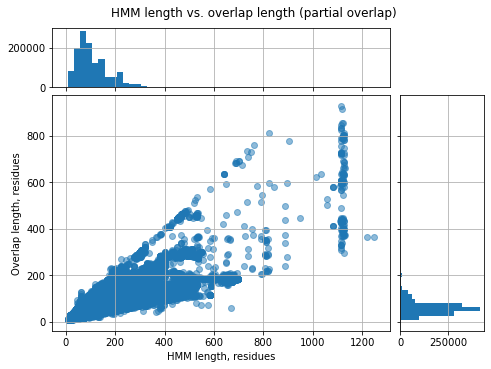

In [34]:
# 2. Scatterplot of HMM length and overlap length - partial overlap
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.15, right=0.9, bottom=0.2, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(partial_overlap["hmm_length"], partial_overlap["overl_len"], alpha=0.5, cmap="Blues")
ax_histx.hist(partial_overlap["hmm_length"], bins=50)
ax_histy.hist(partial_overlap["overl_len"], bins=50, orientation="horizontal")

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_xlabel("HMM length, residues")
ax.set_ylabel("Overlap length, residues")
fig.suptitle("HMM length vs. overlap length (partial overlap)", y=0.95)
ax.grid()
ax_histx.grid()
ax_histy.grid()

plt.savefig("{}/plots/partialoverlap_len.png".format(directory), facecolor="white", dpi=300) 
plt.show()

In [35]:
# No overlap: less than 25%
no_overlap = pfam_clustal[pfam_clustal['overlap_type'] == "no"]

print("The number of pairwise alignments for fully overlapped HMMs: {}".format(len(no_overlap)))
print("The number of unique HMMs: {}".format(no_overlap["hmm_id"].nunique()))
no_overlap.head()

The number of pairwise alignments for fully overlapped HMMs: 12071554
The number of unique HMMs: 2196


,uniprot_id,pfam_id,ipr_id,start_pfam,end_pfam,length_pfam,query_id,hmm_id,hmm_from,hmm_to,...,overl_len,overl_pfam,overl_ali,non_overl_len,overl_perc,overlap_sym,overlap_type,full,no,partial
0,A0A010Q2P2,PF01336,IPR004365,187,267,81,Q1K7R9,Q1K7R9_111-173,1,55,...,0,0.00,0.0,179,0.00,0.00,no,False,True,False
1,A0A010Q2P2,PF04057,IPR007199,7,109,103,Q1K7R9,Q1K7R9_111-173,1,55,...,0,0.00,0.0,161,0.00,0.00,no,False,True,False
2,A0A010Q2P2,PF08646,IPR013955,452,597,146,Q1K7R9,Q1K7R9_111-173,1,55,...,0,0.00,0.0,774,0.00,0.00,no,False,True,False
3,A0A010Q2P2,PF16900,IPR031657,296,393,98,Q1K7R9,Q1K7R9_111-173,1,55,...,0,0.00,0.0,414,0.00,0.00,no,False,True,False
4,A0A010Q304,PF02775,IPR011766,499,646,148,P07342,P07342_580-595,1,16,...,16,10.81,100.0,133,10.81,19.51,no,False,True,False


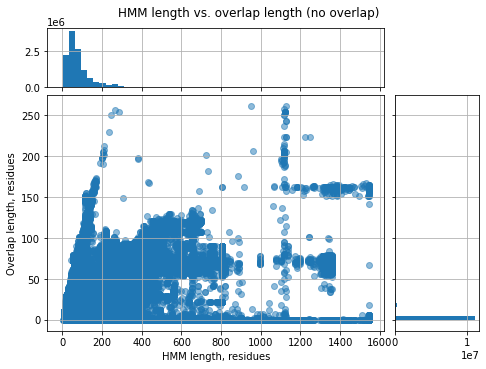

In [36]:
# 3. Scatterplot of HMM length and overlap length - no overlap
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.15, right=0.9, bottom=0.2, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax.scatter(no_overlap["hmm_length"], no_overlap["overl_len"], alpha=0.5, cmap="Blues")
ax_histx.hist(no_overlap["hmm_length"], bins=50)
ax_histy.hist(no_overlap["overl_len"], bins=50, orientation="horizontal")

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_xlabel("HMM length, residues")
ax.set_ylabel("Overlap length, residues")
fig.suptitle("HMM length vs. overlap length (no overlap)", y=0.95)
ax.grid()
ax_histx.grid()
ax_histy.grid()

plt.savefig("{}/plots/nooverlap_len.png".format(directory), facecolor="white", dpi=300) 
plt.show()

Across all three plots, it is evident that for HMMs with a length of about 1100 residues, the variance is higher.
Let’s further examine the models within a range close to this value (I chose the range 1090-1110).

In [37]:
# Print the models based on the type of overlap
print("Total: {} models".format(pfam_clustal["hmm_id"].nunique()))
print("- Fully overlapping: {} models".format(full_overlap["hmm_id"].nunique()))
print("- Partially overlapping: {} models".format(partial_overlap["hmm_id"].nunique()))
print("- No overlapping: {} models".format(no_overlap["hmm_id"].nunique()))

Total: 2200 models
- Fully overlapping: 371 models
- Partially overlapping: 891 models
- No overlapping: 2196 models


In [38]:
# Check if .DS_Store exists in the folder
hmm_path = "{}/results/hmms/hmmbuild".format(directory)

ds_store_path = os.path.join(hmm_path, ".DS_Store")
if os.path.exists(ds_store_path):
    # If it exists, remove the file
    os.remove(ds_store_path)
    print(".DS_Store file removed successfully.")
else:
    print(".DS_Store file does not exist in the folder.")

.DS_Store file does not exist in the folder.


In [39]:
# Retrieve the new instances for which Pfam IDs were not found
hmm_path = "{}/results/hmms/hmmbuild".format(directory)

disprot_hmm_generated = [name.split(".hmm")[0] for name in os.listdir(hmm_path) 
                             if os.path.isfile(os.path.join(hmm_path, name))] # generated HMMs
disprot_hmm_hmmsearch = hmmsearch_results_clustal["hmm_id"].unique() # HMMs found in RP 75%
disprot_hmm_interpro = pfam_clustal["hmm_id"].unique() # HMMs for which Pfam domain was found

non_intersecting_instances_new = len(np.setdiff1d(disprot_hmm_generated, disprot_hmm_hmmsearch)) # generated vs hmmsearch
non_intersecting_instances_hmmsearch = len(np.setdiff1d(disprot_hmm_hmmsearch, disprot_hmm_interpro)) # hmmsearch vs pfam

print("The number of generated DisProt-HMMs: {}".format(len(disprot_hmm_generated)))
print("The number of found DisProt-HMMs by hmmsearch: {}".format(len(disprot_hmm_hmmsearch)))
print("The number of DisProt-HMMs for which Pfam domains were found: {}".format(len(disprot_hmm_interpro)))

The number of generated DisProt-HMMs: 3142
The number of found DisProt-HMMs by hmmsearch: 2536
The number of DisProt-HMMs for which Pfam domains were found: 2200


In [40]:
# Calculate the number of new instances and those non-overlapping with Pfam
print("The number of new DisProt-HMMs: {} ({:.1f}%) from generated {} models".format(
    non_intersecting_instances_new, 
    non_intersecting_instances_new/len(disprot_hmm_generated) * 100,
    len(disprot_hmm_generated)))
print("The number of DisProt-HMMs without Pfam domains found: {} ({:.1f}%) from found {} models in RP 75%".format(
    non_intersecting_instances_hmmsearch, 
    non_intersecting_instances_hmmsearch/len(disprot_hmm_hmmsearch) * 100,
    len(disprot_hmm_hmmsearch)))
print("New DisProt-HMMs, total: {} ({:.1f}%) from generated {} models".format(
    non_intersecting_instances_new + non_intersecting_instances_hmmsearch,
    (non_intersecting_instances_new + non_intersecting_instances_hmmsearch)/len(disprot_hmm_generated) * 100, 
    len(disprot_hmm_generated)))

The number of new DisProt-HMMs: 606 (19.3%) from generated 3142 models
The number of DisProt-HMMs without Pfam domains found: 336 (13.2%) from found 2536 models in RP 75%
New DisProt-HMMs, total: 942 (30.0%) from generated 3142 models


## Orphan HMMs (not found in InterPro)
In this part we will compare the number of generated DisProt HMMs, those found by hmmsearch and having overlap with Pfam-HMMs (383 models).

In [41]:
# Analyse new instances - not found in RP 75%
non_intersecting_hmmbuild = np.setdiff1d(disprot_hmm_generated, disprot_hmm_hmmsearch)
non_intersecting_hmmbuild = non_intersecting_hmmbuild[non_intersecting_hmmbuild != ".DS_Store"]

In [42]:
# Create a data frame of new instances - not found in RP 75%
uniprot_ids = []
hmm_ids = []
starts = []
ends = []
lengths = []

for item in non_intersecting_hmmbuild:
    parts = item.split("_")
    uniprot_id = parts[0]
    hmm_id = item
    start, end = map(int, parts[1].split("-"))
    uniprot_ids.append(uniprot_id)
    hmm_ids.append(hmm_id)
    starts.append(start)
    ends.append(end)
    lengths.append(end - start + 1)

new_hmmbuild_df = pd.DataFrame({"uniprot_id": uniprot_ids, "hmm_id": hmm_ids, "start": starts, "end": ends, "length": lengths})
print("The number of unique Uniprot IDs:", new_hmmbuild_df["uniprot_id"].nunique())
print("The number of unique DisProt-HMMs:", new_hmmbuild_df["hmm_id"].nunique())
new_hmmbuild_df.head()

The number of unique Uniprot IDs: 503
The number of unique DisProt-HMMs: 606


,uniprot_id,hmm_id,start,end,length
0,A0A0H2ZP82,A0A0H2ZP82_40-50,40,50,11
1,A0A0H3CFC9,A0A0H3CFC9_1-22,1,22,22
2,A0A2Z5UJ33,A0A2Z5UJ33_203-212,203,212,10
3,A0A384E149,A0A384E149_414-439,414,439,26
4,A0A3S5Y0Q5,A0A3S5Y0Q5_27-66,27,66,40


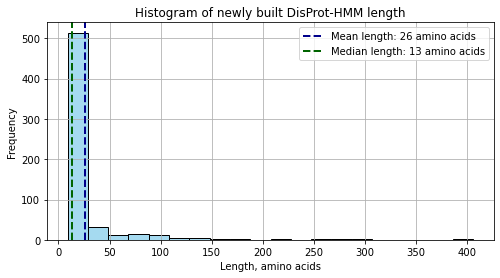

In [43]:
# Histogram of length distribution - not found in RP 75%
plt.figure(figsize=(8, 4))
sns.histplot(new_hmmbuild_df["length"], bins=20, color="skyblue", edgecolor="black")
mean_length = np.mean(new_hmmbuild_df["length"])
median_length = np.median(new_hmmbuild_df["length"])

plt.axvline(x=mean_length, color="darkblue", linestyle="--", linewidth=2, 
            label=f"Mean length: {mean_length:.0f} amino acids")
plt.axvline(x=median_length, color="darkgreen", linestyle="--", linewidth=2, 
            label=f"Median length: {median_length:.0f} amino acids")

plt.xlabel("Length, amino acids")
plt.ylabel("Frequency")
plt.title("Histogram of newly built DisProt-HMM length")
plt.grid()
plt.legend()
plt.savefig("{}/plots/len_histogram.png".format(directory), facecolor="white", dpi=300) 
plt.show()

In [44]:
# Analyse the sequences without found Pfam domain
non_intersecting_hmmsearch = np.setdiff1d(disprot_hmm_hmmsearch, disprot_hmm_interpro)

# Create a data frame 
nopfam_df = gaps_df[gaps_df["hmm_id"].isin(non_intersecting_hmmsearch)]
print("The number of the pairwise alignments of the proteins not found in Pfam:", len(nopfam_df))
print("The number of unique subject proteins not found in Pfam:", nopfam_df["Sequence"].nunique())
nopfam_df.head()

The number of the pairwise alignments of the proteins not found in Pfam: 53564
The number of unique subject proteins not found in Pfam: 42544


,E-value,query_id,hmm_id,Sequence,profile_seq,target_seq,hmm_from,hmm_to,hmm_length,ali_from,ali_to,ali_length,gap_hmm,gap_ali
0,1.400000e-36,A0A068MVV3,A0A068MVV3_1-65,G5J8E1,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,1,65,65,0,0
1,1.700000e-36,A0A068MVV3,A0A068MVV3_1-65,T2JHR4,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,4,68,65,0,0
2,1.700000e-36,A0A068MVV3,A0A068MVV3_1-65,B1X0A9,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAAAEIGVDVEKDYWTTIQ...,1,65,65,1,65,65,0,0
3,1.900000e-36,A0A068MVV3,A0A068MVV3_1-65,B7K2J1,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMIKNRQQSMLERAAAEIGVEVEKDYWTTIQ...,1,65,65,1,65,65,0,0
4,2.200000e-36,A0A068MVV3,A0A068MVV3_1-65,A3IQT3,mstqeqARaLmmrHhhliknRqqsmLnRaaaEvGldvdsdywstiQ...,MSTQQQARALMMRHHQMVKNRQQSMLGRAASEIGVDVETDYWTTIQ...,1,65,65,1,65,65,0,0


In [45]:
# Create a data frame of new instances - not found in Pfam
uniprot_ids = []
hmm_ids = []
starts = []
ends = []
lengths = []

for item in nopfam_df["hmm_id"].unique():
    uniprot_id, positions = item.split("_")
    hmm_id = item
    start, end = map(int, positions.split("-"))
    uniprot_ids.append(uniprot_id)
    hmm_ids.append(hmm_id)
    starts.append(start)
    ends.append(end)
    lengths.append(end - start + 1)

nopfam_len_df = pd.DataFrame({"uniprot_id": uniprot_ids, "hmm_id": hmm_ids, "start": starts, "end": ends, "length": lengths})
print("The number of unique Uniprot IDs:", nopfam_len_df["uniprot_id"].nunique())
print("The number of unique HMM IDs:", nopfam_len_df["hmm_id"].nunique())
nopfam_len_df.head()

The number of unique Uniprot IDs: 294
The number of unique HMM IDs: 336


,uniprot_id,hmm_id,start,end,length
0,A0A068MVV3,A0A068MVV3_1-65,1,65,65
1,A0A097F4I8,A0A097F4I8_1-24,1,24,24
2,A0A097F4I8,A0A097F4I8_74-99,74,99,26
3,A0A2Z5UJ33,A0A2Z5UJ33_73-91,73,91,19
4,A0A2Z5UJ33,A0A2Z5UJ33_8-21,8,21,14


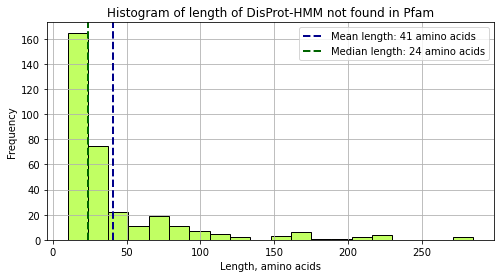

In [46]:
# Histogram of length distribution - no Pfam
plt.figure(figsize=(8, 4))
sns.histplot(nopfam_len_df["length"], bins=20, color="greenyellow", edgecolor="black")

mean_length = np.mean(nopfam_len_df["length"])
median_length = np.median(nopfam_len_df["length"])

plt.axvline(x=mean_length, color="darkblue", linestyle="--", linewidth=2, 
            label=f"Mean length: {mean_length:.0f} amino acids")
plt.axvline(x=median_length, color="darkgreen", linestyle="--", linewidth=2, 
            label=f"Median length: {median_length:.0f} amino acids")

plt.xlabel("Length, amino acids")
plt.ylabel("Frequency")
plt.title("Histogram of length of DisProt-HMM not found in Pfam")
plt.grid()
plt.legend()
plt.savefig("{}/plots/len_histogram_nopfam.png".format(directory), facecolor="white", dpi=300) 
plt.show()

/var/folders/lp/74jh9r6s4zx_dyg2_78l67dw0000gn/T/ipykernel_4692/2201440732.py:16: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


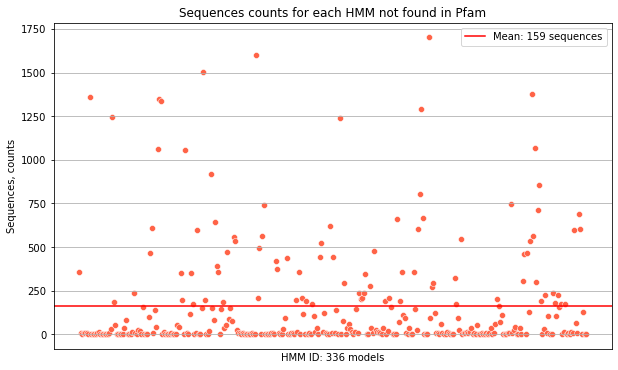

In [51]:
# Plot of sequence counts for HMMs not found in Pfam
seq_counts_nopfam = nopfam_df.groupby("hmm_id")["Sequence"].count().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="hmm_id", y="Sequence", data=seq_counts_nopfam, color="tomato", edgecolors=None)

mean_sequence_count = np.mean(seq_counts_nopfam["Sequence"])
plt.axhline(mean_sequence_count, color="red", label=f"Mean: {mean_sequence_count:.0f} sequences")

plt.xlabel(f"HMM ID: {non_intersecting_instances_hmmsearch} models")
plt.ylabel("Sequences, counts")
plt.title("Sequences counts for each HMM not found in Pfam")
plt.grid()
plt.xticks([])
plt.legend()
# plt.savefig("{}/plots/seqdistribution_nopfam.png".format(directory), facecolor="white", dpi=300) 
plt.show()

## Summarising results
In this section of the notebook, we will examine the distribution of instances: the number of processed and found models decreases at each step, and we need to estimate the amount of information lost. For some proteins, there is no information in the Uniprot BLAST; for others, the ClustalOmega MSA was not generated due to the clusters splitting problem. Some proteins are not found in RP 75%, and the final filtering involves the Pfam database.

In [52]:
# Create a dataframe summarising the number of proteins and the regions at each step
instances_dict = {"Methods": ["Curated DisProt", "Uniprot BLAST", "ClustalOmega", "hmmbuild", "hmmsearch", "Pfam"],
                           "Proteins": [2272, 2271, 2268, 2263, 1971, 1734],
                           "Regions": [3151, 3150, 3147, 3143, 2536, 2200],
                           "% proteins": [100, 99.96, 99.82, 99.6, 86.75, 76.32],
                           "% regions": [100, 99.97, 99.87, 99.75, 80.48, 69.82]}

instances = pd.DataFrame.from_dict(instances_dict)
instances

,Methods,Proteins,Regions,% proteins,% regions
0,Curated DisProt,2272,3151,100.00,100.00
1,Uniprot BLAST,2271,3150,99.96,99.97
2,ClustalOmega,2268,3147,99.82,99.87
3,hmmbuild,2263,3143,99.60,99.75
4,hmmsearch,1971,2536,86.75,80.48
5,Pfam,1734,2200,76.32,69.82
